In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import keras.api._v2.keras as keras #noqa
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras import regularizers
import keras.backend as K

from genreclassification.utils import get_project_root

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

2022-12-09 12:05:51.470255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# multi-layer neural network

---
## data split

In [40]:
df_30 = pd.read_csv(
    get_project_root() / "data/features_30_sec.csv"
)

df_3 = pd.read_csv(
    get_project_root() / "data/features_3_sec.csv"
)

### features / targets:

In [41]:
# get the target labels:
df_3_y = df_3["label"]

# find the training features:
df_3_x = df_3.drop(
    columns=["filename", "length", "label"]
)

### test split before scaling:

In [42]:
x_train, x_test, y_train, y_test = train_test_split(
    df_3_x,
    df_3_y,
    test_size=0.2,
    random_state=42
)

In [43]:
for d in [
    (x_train, "x_train"),
    (y_train, "y_train"),
    (x_test, " x_test"),
    (y_test, " y_test")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train: (7992, 57)
y_train: (7992,)
 x_test: (1998, 57)
 y_test: (1998,)


### MinMax scaling for the training set:

In [44]:
scaler = MinMaxScaler((0,1))
# scale fetures and get column names
scale_cols = x_train.columns
x_scaled = scaler.fit_transform(x_train[scale_cols])
# retrieve column names for scaled df:
x_train_scaled = pd.DataFrame(
    x_scaled,
    columns=scale_cols
)


---
## mlnn

### split training set into training and validation

In [45]:
x_train_scaled, x_val_scaled, y_train, y_val = train_test_split(
    x_train_scaled,
    y_train,
    test_size=0.2,
    random_state=42
)

In [48]:
for d in [
    (x_train_scaled, "x_train_scaled"),
    (y_train, "       y_train"),
    (x_val_scaled, "  x_val_scaled"),
    (y_val, "         y_val")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train_scaled: (6393, 57)
       y_train: (6393,)
  x_val_scaled: (1599, 57)
         y_val: (1599,)


### encoding the categorical classes
* the model will produce a probability score for each of the 10 classes, assigning the most likely label

In [49]:
# start by mapping the labels to numerical values:
catno_to_label = {key:value for (key, value) in enumerate(sorted(set(y_train)))}
catno_to_label

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [50]:
# reverse this:
label_to_catno = {v:k for k,v in catno_to_label.items()}
label_to_catno

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [51]:
y_train = y_train.map(label_to_catno)
y_val = y_val.map(label_to_catno)

In [52]:
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
# y_val = label_as_binary.fit_transform(y_val)
y_val = label_as_binary.transform(y_val)

In [53]:
for d in [
    (x_train_scaled, "x_train_scaled"),
    (y_train, "       y_train"),
    (x_val_scaled, "  x_val_scaled"),
    (y_val, "         y_val")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train_scaled: (6393, 57)
       y_train: (6393, 10)
  x_val_scaled: (1599, 57)
         y_val: (1599, 10)


---

### sequential model: 1 input layer, 3 hidden layers, 1 output layer (all dense)

In [55]:
model = Sequential(name="mlnn_genre_classification")
#input layer
model.add(Dense(
    units=32,
    activation="selu",
    # kernel_regularizer=regularizers.l2(0.01),
    input_shape=(x_train_scaled.shape[1],),
    name="input")
)
# batch normalistion:
model.add(BatchNormalization())
# dropout
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(
    units=128,
    activation="selu",
    # kernel_regularizer=regularizers.l2(0.01),
    name="hidden1"
))
# batch normalistion:
model.add(BatchNormalization())
# dropout
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(
    units=128,
    activation="selu",
    # kernel_regularizer=regularizers.l2(0.01),
    name="hidden2"
))
# batch normalistion:
model.add(BatchNormalization())
# dropout
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(
    units=128,
    activation="selu",
    # kernel_regularizer=regularizers.l2(0.01),
    name="hidden3"
))
# batch normalistion:
model.add(BatchNormalization())
# dropout
model.add(Dropout(0.2))
# output layer
model.add(Dense(
    units=10,
    activation="softmax",
    name="output"
))

In [56]:
model.summary()

Model: "mlnn_genre_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 hidden1 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 128) 

### compile model and define loss function

In [57]:
# help(optimizers.Adam)

In [58]:
# learning rate:
lr = 0.0001

In [59]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=lr),
    # optimizer=optimizers.SGD(learning_rate=lr),
    metrics=["accuracy"]
)

### training the model

In [60]:
history = History()

# restore best model by val_loss
# patience == num epochs so doesn't actually stop early
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    restore_best_weights=True,
    patience=700,
    baseline=None
)

# checkpoint = ModelCheckpoint(
#     get_project_root() / "models/checkpoint/",
#     save_best_only=True
# )

model.fit(
    x_train_scaled,
    y_train,
    epochs=700,
    batch_size=32,
    verbose=1,
    validation_data=(x_val_scaled, y_val),
    callbacks=[
        history,
        early_stopping,
        # checkpoint
    ]
)

Epoch 1/700
200/200 [==============================] - 2s 5ms/step - loss: 2.2612 - accuracy: 0.2645 - val_loss: 1.6622 - val_accuracy: 0.4465
Epoch 2/700
200/200 [==============================] - 1s 3ms/step - loss: 1.8413 - accuracy: 0.3620 - val_loss: 1.3579 - val_accuracy: 0.5116
Epoch 3/700
200/200 [==============================] - 1s 3ms/step - loss: 1.7179 - accuracy: 0.4037 - val_loss: 1.2598 - val_accuracy: 0.5453
Epoch 4/700
200/200 [==============================] - 1s 3ms/step - loss: 1.6494 - accuracy: 0.4201 - val_loss: 1.2111 - val_accuracy: 0.5591
Epoch 5/700
200/200 [==============================] - 1s 3ms/step - loss: 1.5716 - accuracy: 0.4463 - val_loss: 1.1783 - val_accuracy: 0.5829
Epoch 6/700
200/200 [==============================] - 1s 3ms/step - loss: 1.5400 - accuracy: 0.4547 - val_loss: 1.1511 - val_accuracy: 0.5997
Epoch 7/700
200/200 [==============================] - 1s 3ms/step - loss: 1.5188 - accuracy: 0.4661 - val_loss: 1.1307 - val_accuracy: 0.5985

In [61]:
# training metrics available to plot:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

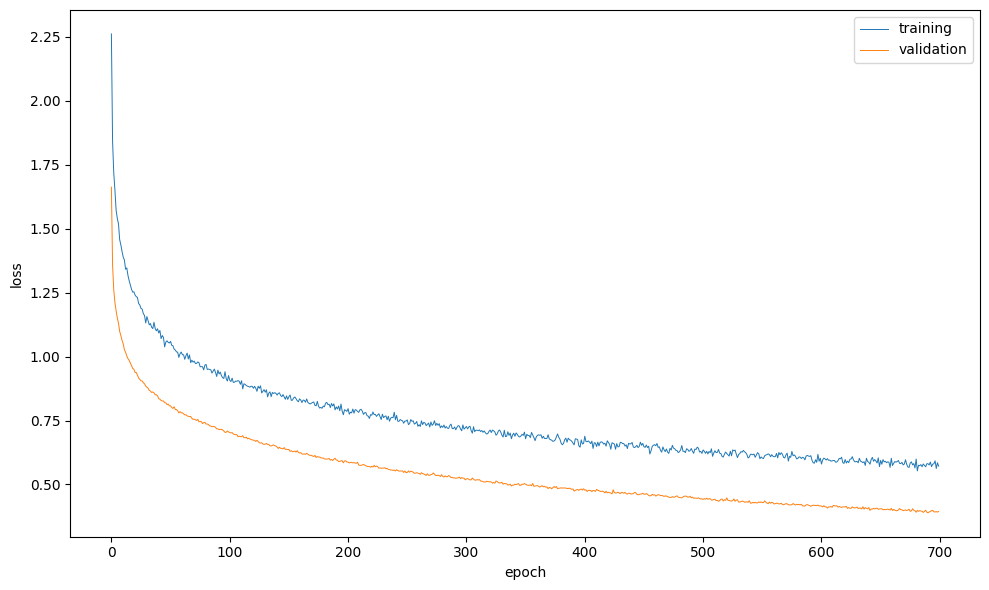

In [62]:
fig = plt.figure(
    figsize=(10,6)
)
ax = fig.add_subplot(111)

ax.plot(history.history["loss"], label="training", linewidth=0.7)
ax.plot(history.history["val_loss"], label="validation", linewidth=0.7)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

fig.tight_layout()

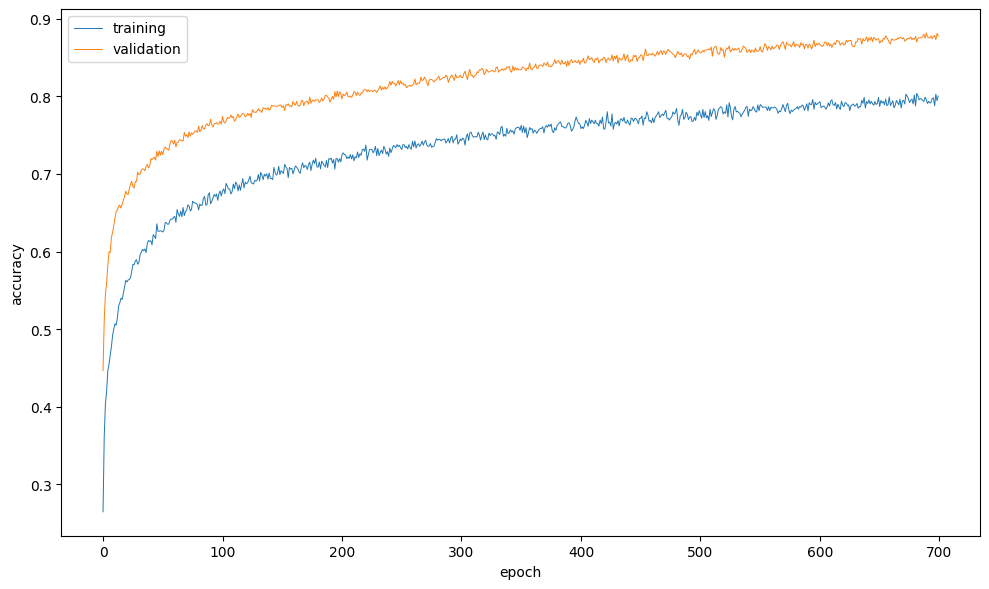

In [63]:
fig = plt.figure(
    figsize=(10,6)
)
ax = fig.add_subplot(111)

ax.plot(history.history["accuracy"], label="training", linewidth=0.7)
ax.plot(history.history["val_accuracy"], label="validation", linewidth=0.7)

ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()

fig.tight_layout()

### save training fig:

In [64]:
# fig.savefig(
#     get_project_root() / "models/60pc/train-val.svg"
# )

### save model:

In [65]:
# model.save(
#     get_project_root() / "models/60pc/60pc"
# )

### load model:

In [66]:
# model = load_model(
#     get_project_root() / "models/60pc/60pc"
# )

### recall model params:

In [67]:
model.summary()
print(f"""
  number of epochs: {len(history.history["loss"])}
     loss function: {model.loss}
   model optimiser: {model.optimizer.get_config()["name"]}
     learning rate: {model.optimizer.get_config()["learning_rate"]}
evaluation metrics: {list(history.history.keys())}
_________________________________________________________________
"""
)

Model: "mlnn_genre_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 hidden1 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 128) 

## performance on test set

In [69]:
# scale the x_test with the same scaler as used on the training set:
scale_cols = x_test.columns
x_test_scaled = scaler.transform(x_test[scale_cols])
# retrieve column names for scaled df:
x_test_scaled = pd.DataFrame(
    x_test_scaled,
    columns=scale_cols
)

In [70]:
x_test_scaled

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.449989,0.772012,0.202143,0.019575,0.190181,0.096897,0.432013,0.185702,0.276373,0.216050,0.099440,0.017718,0.611500,0.029937,0.423830,0.042502,0.385714,0.582241,0.082467,0.534241,0.146313,0.656199,0.129500,0.685751,0.088448,0.439493,0.143566,0.634225,0.143801,0.403169,0.225377,0.514752,0.195413,0.343415,0.301285,0.507395,0.217236,0.293207,0.165537,0.451256,0.101942,0.384255,0.141608,0.452127,0.083472,0.505600,0.124484,0.547183,0.080034,0.338559,0.093698,0.377247,0.020590,0.394629,0.019861,0.396216,0.037228
1,0.194069,0.652902,0.201970,0.028512,0.147884,0.010029,0.284852,0.023778,0.210476,0.044564,0.112296,0.001862,0.621177,0.054857,0.512936,0.010689,0.285195,0.582452,0.031721,0.629532,0.021698,0.486484,0.078193,0.735011,0.033480,0.195426,0.036778,0.579729,0.037128,0.418634,0.070459,0.230153,0.134688,0.417521,0.195442,0.335130,0.054967,0.350586,0.024463,0.305139,0.027233,0.330475,0.031235,0.439520,0.017058,0.607560,0.031533,0.391525,0.035364,0.340800,0.041620,0.219801,0.017475,0.299011,0.039630,0.263347,0.013691
2,0.371712,0.673366,0.293521,0.036694,0.367201,0.038280,0.500184,0.108579,0.459383,0.076872,0.330766,0.026141,0.563566,0.062236,0.304384,0.083954,0.361781,0.737057,0.040414,0.427978,0.053309,0.412394,0.122685,0.770381,0.037693,0.330706,0.088682,0.745734,0.088251,0.452785,0.153374,0.544889,0.148831,0.288876,0.082496,0.609546,0.097767,0.260632,0.073841,0.493694,0.084879,0.355752,0.083361,0.574800,0.039555,0.320811,0.048232,0.485503,0.094528,0.336853,0.046367,0.286379,0.062249,0.314305,0.034305,0.393009,0.037573
3,0.423009,0.729716,0.337213,0.165009,0.118684,0.026635,0.331319,0.123406,0.162102,0.083882,0.054862,0.006006,0.631218,0.144121,0.557822,0.064098,0.553247,0.609009,0.106317,0.614190,0.041629,0.612052,0.032569,0.534298,0.075831,0.522287,0.197815,0.608692,0.092104,0.517211,0.239552,0.412655,0.206447,0.483127,0.187652,0.391049,0.110017,0.276477,0.168622,0.453371,0.160932,0.414826,0.167758,0.463884,0.090629,0.492449,0.055507,0.508430,0.088176,0.297954,0.095739,0.372051,0.036296,0.426896,0.036249,0.344422,0.019860
4,0.474132,0.607292,0.345348,0.046319,0.456982,0.016879,0.575128,0.011407,0.584442,0.015150,0.455612,0.026039,0.631403,0.097347,0.538001,0.068470,0.511364,0.809714,0.011753,0.363608,0.024097,0.406260,0.015783,0.640704,0.024886,0.342700,0.013114,0.796561,0.037862,0.340343,0.038487,0.645165,0.043423,0.426278,0.033874,0.618962,0.035616,0.234698,0.042316,0.473903,0.035792,0.292255,0.030173,0.575354,0.037905,0.444142,0.035045,0.658404,0.039509,0.354885,0.041044,0.423566,0.042813,0.309644,0.049756,0.466007,0.062340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,0.353861,0.727413,0.462426,0.131802,0.535930,0.137484,0.770800,0.121586,0.691462,0.183583,0.422787,0.113554,0.632233,0.208944,0.567801,0.144537,0.601113,0.836358,0.050057,0.301087,0.140727,0.545914,0.038071,0.347098,0.085105,0.588526,0.070022,0.374424,0.140104,0.602100,0.106282,0.324235,0.110860,0.546938,0.131222,0.323872,0.143254,0.459107,0.057256,0.359422,0.043479,0.508716,0.017119,0.397708,0.031509,0.505509,0.057229,0.475220,0.050394,0.470580,0.077828,0.412393,0.100

* would be good practice to code this into a pipeline

In [71]:
pred = model.predict(x_test_scaled)

63/63 [==============================] - 0s 1ms/step


In [72]:
pred_class = np.argmax(pred, axis=1)
pred_class = pd.Series(pred_class)
# pred_class

In [73]:
pred_class = pred_class.map(catno_to_label)

In [74]:
y_test.reset_index(drop=True, inplace=True)

In [75]:
cm = confusion_matrix(
    y_test,
    pred_class
)
cm

array([[179,   1,  12,   2,   0,   5,   1,   0,   3,   5],
       [  1, 199,   0,   0,   0,   3,   0,   0,   0,   0],
       [ 11,   1, 162,   2,   0,   6,   0,   1,   0,   3],
       [  2,   4,   6, 171,   3,   0,   3,   1,   3,   6],
       [  2,   2,   5,   5, 188,   0,   2,   4,   9,   1],
       [  4,  10,   4,   0,   0, 174,   0,   0,   0,   0],
       [  1,   0,   5,   2,   2,   0, 192,   0,   0,   2],
       [  1,   0,   3,   2,   1,   3,   0, 168,   1,   1],
       [  2,   1,   4,   9,   5,   4,   0,   4, 176,   6],
       [  4,   2,   7,  11,   1,   1,   9,   3,   5, 154]])

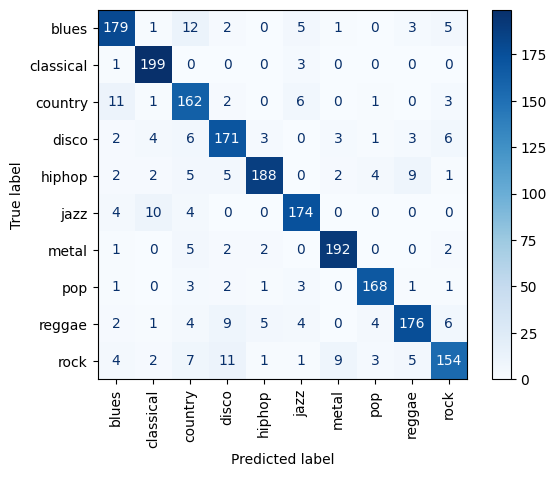

In [76]:
ConfusionMatrixDisplay(
    cm,
    display_labels=label_to_catno.keys()
).plot(
    xticks_rotation=90,
    cmap="Blues"
)

In [77]:
def average_metrics(y_test, y_pred):
    scorers = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_micro": f1_score(y_test, y_pred, average="micro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "recall_micro": recall_score(y_test, y_pred, average="micro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "precision_micro": precision_score(y_test, y_pred, average="micro"),
        "precision_macro": precision_score(y_test, y_pred, average="macro")
    }
    df = pd.DataFrame(index=scorers.keys(), columns=["metric score"])
    for scorer in scorers.keys():
        df.at[scorer, "metric score"] = scorers[scorer]
    df=df.transpose()
    return df

def class_metrics(y_test, y_pred, class_labels):
    df = pd.DataFrame(index=list(class_labels))

    for scorer in [
        ("recall", recall_score),
        ("precision", precision_score),
        ("f1", f1_score)
    ]:
        metric_score = scorer[1](
            y_test,
            y_pred,
            average=None,
            labels=list(class_labels)
        )
        df[scorer[0]] = metric_score

    df = df.transpose()

    return df

In [78]:
average_metrics(y_test, pred_class)

,accuracy,f1_micro,f1_macro,recall_micro,recall_macro,precision_micro,precision_macro
metric score,0.882382,0.882382,0.882008,0.882382,0.883013,0.882382,0.88284


In [79]:
class_metrics(y_test, pred_class, label_to_catno.keys())

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
recall,0.860577,0.980296,0.870968,0.859296,0.862385,0.906250,0.941176,0.933333,0.834123,0.781726
precision,0.864734,0.904545,0.778846,0.838235,0.940000,0.887755,0.927536,0.928177,0.893401,0.865169
f1,0.862651,0.940898,0.822335,0.848635,0.899522,0.896907,0.934307,0.930748,0.862745,0.821333


## scrap

In [162]:
# model.get_config()

In [66]:
# model._get_compile_args()

In [67]:
# dir(model)

## notes:
* built the model layer by layer and experimented with different architectures and activation functions until saw some results
* relu having much better performance than sigmoid
* saw some overfitting, so will try regularisation and dropout to rectify
* then will plan a parameter grid for hyperparameter tuning by sklearn gridsearch

* scaled the input then didn't use it -> now fixed!

## hyperparameter gridsearch:
* learning rate
* batch size
* kernel initialiser
* maybe activation functions
* model optimiser
* dropout rate
* hidden dimensions
